# ***화승***

## ***IMPORT LIBRARY***
---

In [2]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

## ***Load Dataset***
---

In [3]:
### Cluster Dict 
cluster_dict = {
        'cluster1': {'products': ["FFWED70284","FFWED70007","FFWED70267","FFWED70103","FFWED70199","FFSED70438","FFWED70033",
                                "FFWES60194","FFSED70498","FFSED70533","FFWED70321"],
                    'var': 'T5'},
        'cluster2': {'products': ["FFWED70019","FFWED70102","FFWED70283","FFHED70076","FFWED70338",
                                "FFHED70014","FFSED70032","FFHED70147",
                                "FFHED60009","FFHED60006"],
                    'var': 'T3'},
        'cluster3': {'products': ["HCSED50105", "HCSED60072",
                                "HCWED60031", "HCSED50391", "HCSED70092", "HCSED60024",],
                    'var': 'M/B 점도 (ML)'},
        'cluster4': {'products': ["HCSED60010", "HCSES60015", "HCWES60017",
                                "HCSED70584", "HCSED60530", "HCSED50047",
                                "HCSED40011", "HCSED20006",
                                "HCWED70019", "FCHED60002", "FCWED70009",
                                "HCSED60017", "HCSED70143"],
                    'var': 'M/B 점도 (MS)'}
        }

# Random Seed & Path 
random_seed = 22
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'

# Product 정의 
train_cluster = "cluster4"
p_codes = cluster_dict['cluster4']['products']  

# Target 
target_list = ["Ct 90"] + ["Scorch (T5)", "Scorch (T3)"] + ['Vm (T5)', "Vm (T3)", "M/B 점도 (ML)", "M/B 점도 (MS)"] + ["경도"]

# Data Import 
        # Log 
log_df = pd.read_csv(f"{path}/log_df_10s.csv")
log_df = log_df[log_df["제품코드"].isin(cluster_dict[train_cluster]["products"])] 
        # QA 
qa_df = pd.read_csv(f"{path}/qa_df.csv") 
        # Recipe
recipe_df = pd.read_csv(f"{path}/recipe_df.csv") 
        # INFO 
info = pd.read_excel(f"{path}/투입자재 CODE별 비중 정보.xlsx", header=1, index_col=0).reset_index(drop=True)
        # Weather 
weather_df = pd.read_csv(f"{path}/weather_dg.csv")
weather_df["연월일"] = weather_df["연월일"].astype(str)

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (1291850, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [4]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (1228556, 39)
Log Train Dataset: (13508, 18)


In [5]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df, p_codes, target_list)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (5549, 4)
Qa Train Dataset: (5548, 5)


In [6]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [7]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)


Daset Shape: (13508, 26)


In [8]:
### Cluster label 생성 
clst = {1: ['FFWED70267', 'FFWED70033'],
        2: ['FFWED70007', 'FFWED70103'],
        3: ['FFSED70498', 'FFWED70321'],
        4: ['FFSED70438', 'FFSED70533'],
        5: ['FFWES60194'],
        6: ['FFWED70284', 'FFWED70199']}

# 1) 제품코드 추출
df3["제품코드_extracted"] = df3["작업지시번호-배치"].str[6:16]

# 2) 매핑 dict 생성
code_to_cluster = {c: k for k, codes in clst.items() for c in codes}

# 3) 매핑 적용 
df3["cluster"] = df3.get("cluster", pd.Series(index=df3.index))
df3["cluster"] = df3["cluster"].fillna(df3["제품코드_extracted"].map(code_to_cluster))
df3["cluster"] = df3["cluster"].astype("Int64")

df3 = df3.drop(columns=["제품코드_extracted"])
dataset = df3.drop(columns=['cluster']).reset_index(drop=True).copy()  

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (13508, 26)


In [11]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = ['cycle time','M/B 점도 (ML)_결과','M/B 점도 (MS)_결과',]

dataset[target_lst].count()

cycle time        13419
M/B 점도 (ML)_결과     4094
M/B 점도 (MS)_결과      565
dtype: int64

## ***MODELLING***
---

In [12]:
### Train Test Split 
# Targets 
targets = ['cycle time','M/B 점도 (ML)_결과','M/B 점도 (MS)_결과',]

# Cycle Time 
cycle_train_dataset, cycle_test_dataset = create_train_test_dataset(dataset, targets[0])

# M/B 점도 (ML)_결과 
ml_train_dataset, ml_test_dataset = create_train_test_dataset(dataset, targets[1])

# M/B 점도 (MS)_결과 
ms_train_dataset, ms_test_dataset = create_train_test_dataset(dataset, targets[2])


# Print 
print('='*100)
print(f"{'cycle time':<21} | {len(cycle_train_dataset):>14,} | {len(cycle_test_dataset):>13,}")
print(f"{'M/B 점도 (ML)_결과':<19} | {len(ml_train_dataset):>14,} | {len(ml_test_dataset):>13,}")
print(f"{'M/B 점도 (MS)_결과':<19} | {len(ms_train_dataset):>14,} | {len(ms_test_dataset):>13,}")
print("="*100)

cycle time            |          7,782 |         1,826
M/B 점도 (ML)_결과      |          2,410 |           566
M/B 점도 (MS)_결과      |            232 |            55


[I 2025-10-21 08:29:20,785] A new study created in memory with name: no-name-f4c38f88-bf01-44bd-9c3b-ccfbee22426b


학습할 Tree Features: 19 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 7782


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-21 08:29:24,775] Trial 0 finished with value: 10.719574249497343 and parameters: {'n_estimators': 2970, 'max_depth': 9, 'learning_rate': 0.2676880558424416, 'subsample': 0.7354748301401105, 'gamma': 0.17459969716789087, 'reg_lambda': 0.0010037455897748523}. Best is trial 0 with value: 10.719574249497343.
[I 2025-10-21 08:29:35,507] Trial 1 finished with value: 8.999277329623382 and parameters: {'n_estimators': 1780, 'max_depth': 11, 'learning_rate': 0.007520618630755188, 'subsample': 0.8625670687933614, 'gamma': 0.42658004939514954, 'reg_lambda': 1.785841424006335}. Best is trial 1 with value: 8.999277329623382.
[I 2025-10-21 08:29:44,719] Trial 2 finished with value: 9.269540105461415 and parameters: {'n_estimators': 1837, 'max_depth': 8, 'learning_rate': 0.006246762265220207, 'subsample': 0.9424726712013559, 'gamma': 0.16086657160001117, 'reg_lambda': 0.5035379520345142}. Best is trial 1 with value: 8.999277329623382.
[I 2025-10-21 08:29:45,761] Trial 3 finished with value

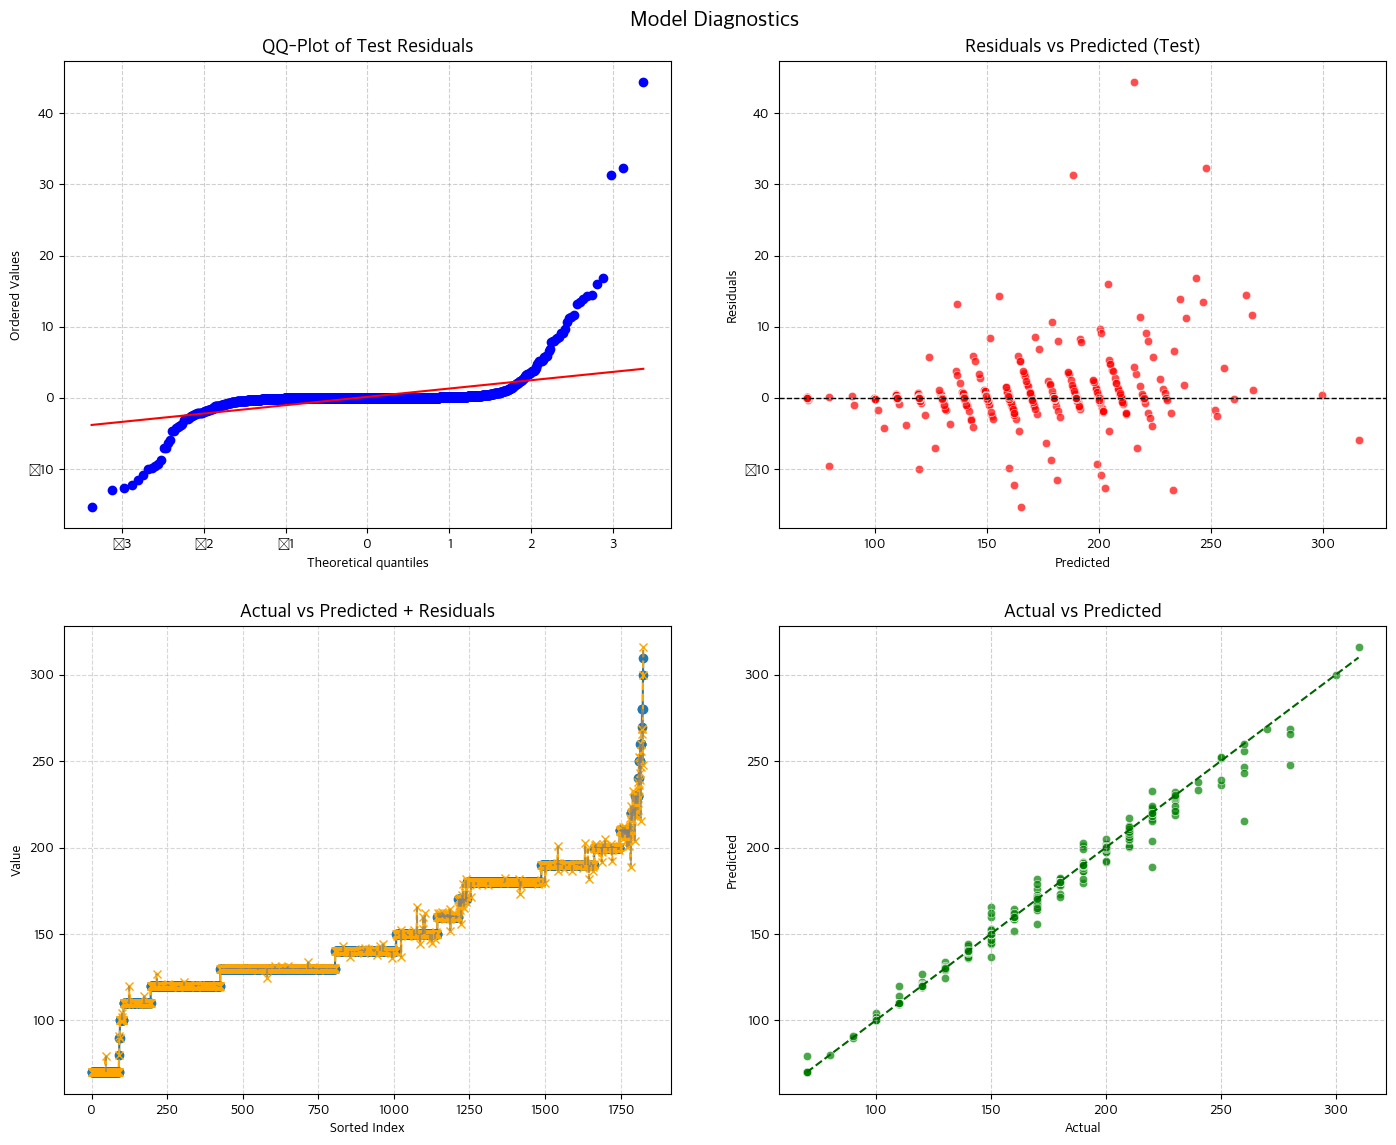

[I 2025-10-21 08:30:41,491] A new study created in memory with name: no-name-ff5f5178-82f9-4cea-a5a8-c238481bbe09


Train Accuracy
Train RMSE : 0.294
Train R2   : 1.000
Train SMAPE : 0.07
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 2.258
Test R2   : 0.996
Test SMAPE : 0.29
학습할 Tree Features: 19 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 2410


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-21 08:30:43,994] Trial 0 finished with value: 1.3261013257468466 and parameters: {'n_estimators': 1254, 'max_depth': 9, 'learning_rate': 0.023114967743703044, 'subsample': 0.9740119364402413, 'gamma': 0.21208241674249262, 'reg_lambda': 0.00803742350960007}. Best is trial 0 with value: 1.3261013257468466.
[I 2025-10-21 08:30:46,931] Trial 1 finished with value: 1.2175125810621779 and parameters: {'n_estimators': 2146, 'max_depth': 7, 'learning_rate': 0.05044955484405247, 'subsample': 0.7100664141620365, 'gamma': 0.4021667297666816, 'reg_lambda': 0.04703048007779738}. Best is trial 1 with value: 1.2175125810621779.
[I 2025-10-21 08:31:00,471] Trial 2 finished with value: 1.410850247737905 and parameters: {'n_estimators': 1946, 'max_depth': 11, 'learning_rate': 0.001418476018225381, 'subsample': 0.950222195135028, 'gamma': 0.42308021511291644, 'reg_lambda': 0.01286806471622985}. Best is trial 1 with value: 1.2175125810621779.
[I 2025-10-21 08:31:07,818] Trial 3 finished with va

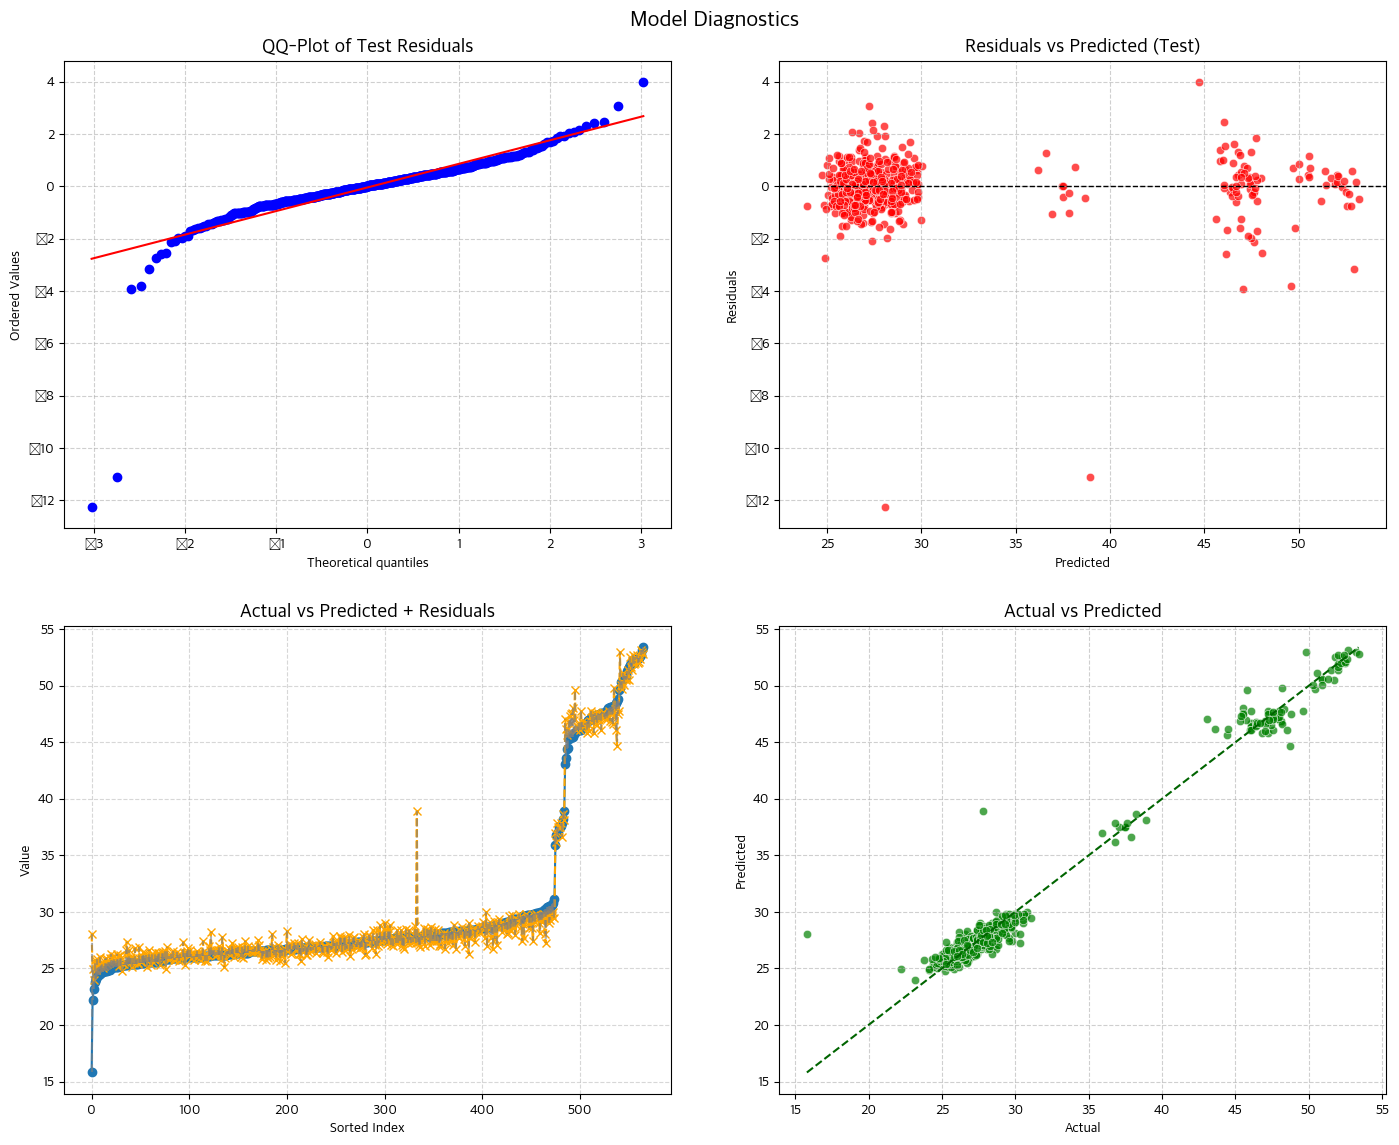

[I 2025-10-21 08:31:42,657] A new study created in memory with name: no-name-068de1bf-ee7d-4d06-b515-c101daa0db40


Train Accuracy
Train RMSE : 0.203
Train R2   : 0.999
Train SMAPE : 0.54
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.067
Test R2   : 0.981
Test SMAPE : 2.10
학습할 Tree Features: 19 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 232


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-21 08:31:52,600] Trial 0 finished with value: 1.9200979430096556 and parameters: {'n_estimators': 2785, 'max_depth': 10, 'learning_rate': 0.0012477194733703052, 'subsample': 0.8448726038146472, 'gamma': 0.24415434533087427, 'reg_lambda': 0.139920980206428}. Best is trial 0 with value: 1.9200979430096556.
[I 2025-10-21 08:31:59,707] Trial 1 finished with value: 1.8915084534510689 and parameters: {'n_estimators': 2538, 'max_depth': 6, 'learning_rate': 0.0010613743765100951, 'subsample': 0.8040120980770725, 'gamma': 0.3629786472057266, 'reg_lambda': 0.0014887154747651224}. Best is trial 1 with value: 1.8915084534510689.
[I 2025-10-21 08:32:03,488] Trial 2 finished with value: 1.9105087429729721 and parameters: {'n_estimators': 1052, 'max_depth': 10, 'learning_rate': 0.003463139010084118, 'subsample': 0.8180925345972198, 'gamma': 0.2113899565508881, 'reg_lambda': 0.0024146029923510356}. Best is trial 1 with value: 1.8915084534510689.
[I 2025-10-21 08:32:06,585] Trial 3 finished 

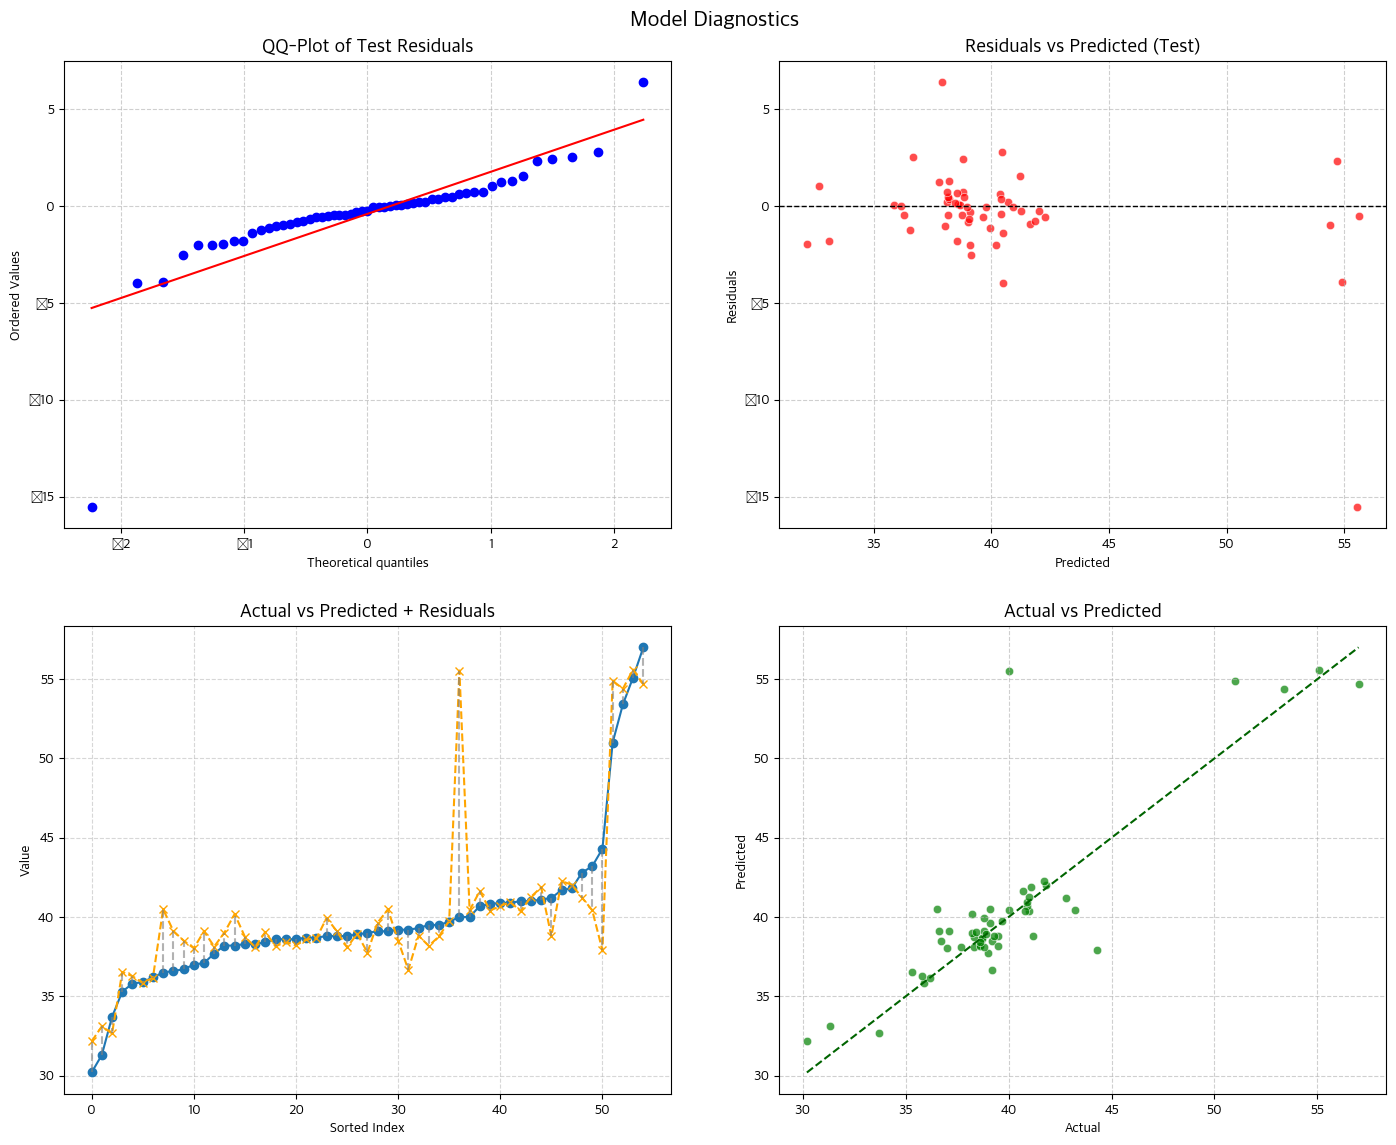

Train Accuracy
Train RMSE : 0.197
Train R2   : 0.999
Train SMAPE : 0.40
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 2.644
Test R2   : 0.690
Test SMAPE : 3.33


In [13]:
### Modelling 
# Cycle Time 
cycle_model, cycle_importance = train_tree(cycle_train_dataset, cycle_test_dataset, target_col='cycle time')

# M/B 점도 (ML)_결과 
ml_model, ml_importance = train_tree(ml_train_dataset, ml_test_dataset, target_col='M/B 점도 (ML)_결과')

# M/B 점도 (MS)_결과 
ms_model, ms_importance = train_tree(ms_train_dataset, ms_test_dataset, target_col='M/B 점도 (MS)_결과')

In [14]:
### Feature Importance 
print('='*100)
print('Cycle Time')
print(cycle_importance)
print('-'*100)
print('M/B 점도 (ML)_결과')
print(ml_importance)
print('-'*100)
print('M/B 점도 (MS)_결과')
print(ms_importance)
print('='*100)

Cycle Time
              Feature  Importance  rank
0          step1_time    0.599157     1
1          step3_time    0.195657     2
2           step3_전력량    0.094823     3
3   step2_Rotor speed    0.031099     4
4   step3_Rotor speed    0.026508     5
5   step1_Rotor speed    0.014336     6
6          step2_time    0.012559     7
7           step2_전력량    0.005740     8
8           step1_전력량    0.003664     9
9         step1_mix온도    0.003237    10
10        step3_mix온도    0.002989    11
11       step2_Ram 압력    0.002350    12
12       step3_Ram 압력    0.001948    13
13             TA_AVG    0.001861    14
14                필팩터    0.001533    15
15       step1_Ram 압력    0.000736    16
16        step2_mix온도    0.000699    17
17             TA_MIN    0.000557    18
18             TA_MAX    0.000547    19
----------------------------------------------------------------------------------------------------
M/B 점도 (ML)_결과
              Feature  Importance  rank
0                 필팩터    0.548826

[I 2025-10-21 08:53:42,162] A new study created in memory with name: no-name-b0122e3c-a600-4d9b-ab7a-6e28b2421fa7


학습할 Tree Features: 8 | ['step1_Ram 압력', 'step1_Rotor speed', 'step1_mix온도', 'step1_전력량', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 7521


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-21 08:53:55,680] Trial 0 finished with value: 3.4960711465044576 and parameters: {'n_estimators': 1959, 'max_depth': 10, 'learning_rate': 0.006106223408747869, 'subsample': 0.9271742235618265, 'gamma': 0.05048351648464744, 'reg_lambda': 0.015209071857303729}. Best is trial 0 with value: 3.4960711465044576.
[I 2025-10-21 08:54:04,805] Trial 1 finished with value: 4.55084930489103 and parameters: {'n_estimators': 2571, 'max_depth': 7, 'learning_rate': 0.0014844049721258106, 'subsample': 0.7315750674735726, 'gamma': 0.03160443075564162, 'reg_lambda': 2.29547667852815}. Best is trial 0 with value: 3.4960711465044576.
[I 2025-10-21 08:54:07,716] Trial 2 finished with value: 10.98885022135095 and parameters: {'n_estimators': 604, 'max_depth': 9, 'learning_rate': 0.0010397521590726265, 'subsample': 0.8781857501010234, 'gamma': 0.149759817145861, 'reg_lambda': 0.43281211327670993}. Best is trial 0 with value: 3.4960711465044576.
[I 2025-10-21 08:54:10,152] Trial 3 finished with valu

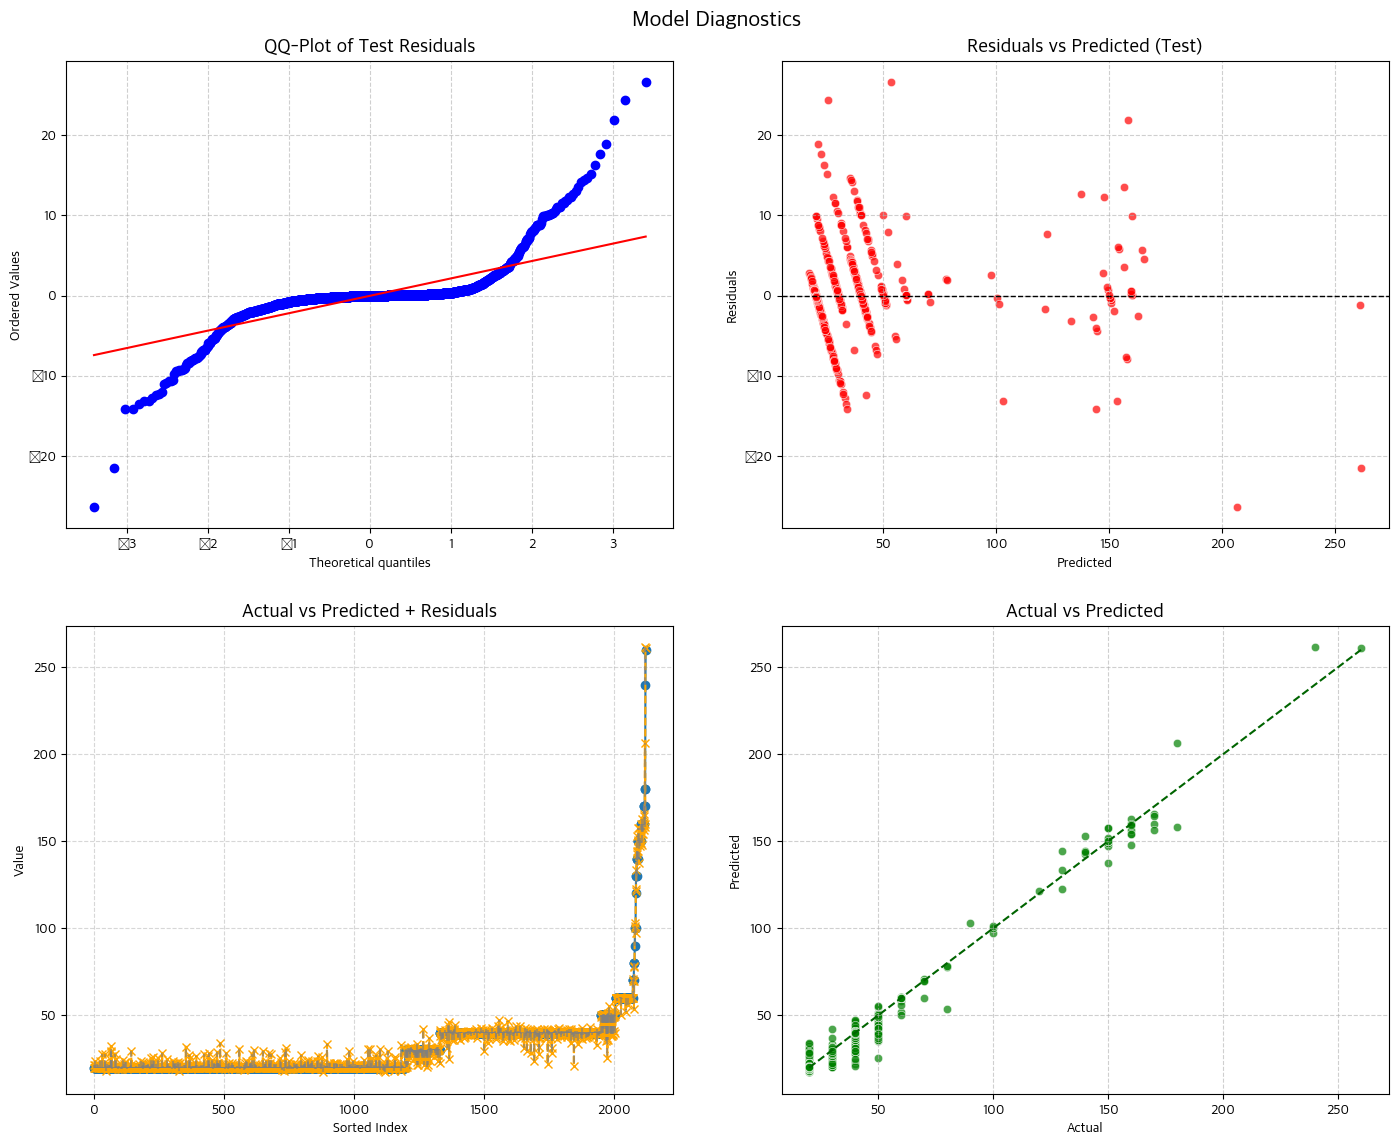

[I 2025-10-21 08:54:55,574] A new study created in memory with name: no-name-4099e720-03f6-442b-93fb-ee4a9e27463a


Train Accuracy
Train RMSE : 1.001
Train R2   : 0.997
Train SMAPE : 1.76
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 2.802
Test R2   : 0.983
Test SMAPE : 3.71
학습할 Tree Features: 8 | ['step3_Ram 압력', 'step3_Rotor speed', 'step3_mix온도', 'step3_전력량', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 7494


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-21 08:55:02,435] Trial 0 finished with value: 13.010900472386169 and parameters: {'n_estimators': 2629, 'max_depth': 6, 'learning_rate': 0.031410120328725935, 'subsample': 0.8596759528921669, 'gamma': 0.40459525846962296, 'reg_lambda': 0.007620398811540226}. Best is trial 0 with value: 13.010900472386169.
[I 2025-10-21 08:55:14,870] Trial 1 finished with value: 10.288383936247731 and parameters: {'n_estimators': 2492, 'max_depth': 10, 'learning_rate': 0.0039052006865301797, 'subsample': 0.825032628953804, 'gamma': 0.20795949153435117, 'reg_lambda': 2.8853731985919695}. Best is trial 1 with value: 10.288383936247731.
[I 2025-10-21 08:55:21,402] Trial 2 finished with value: 14.231602020654144 and parameters: {'n_estimators': 1290, 'max_depth': 12, 'learning_rate': 0.01326930689343739, 'subsample': 0.8237688398485837, 'gamma': 0.2249914346659015, 'reg_lambda': 0.012211840591102906}. Best is trial 1 with value: 10.288383936247731.
[I 2025-10-21 08:55:25,573] Trial 3 finished wit

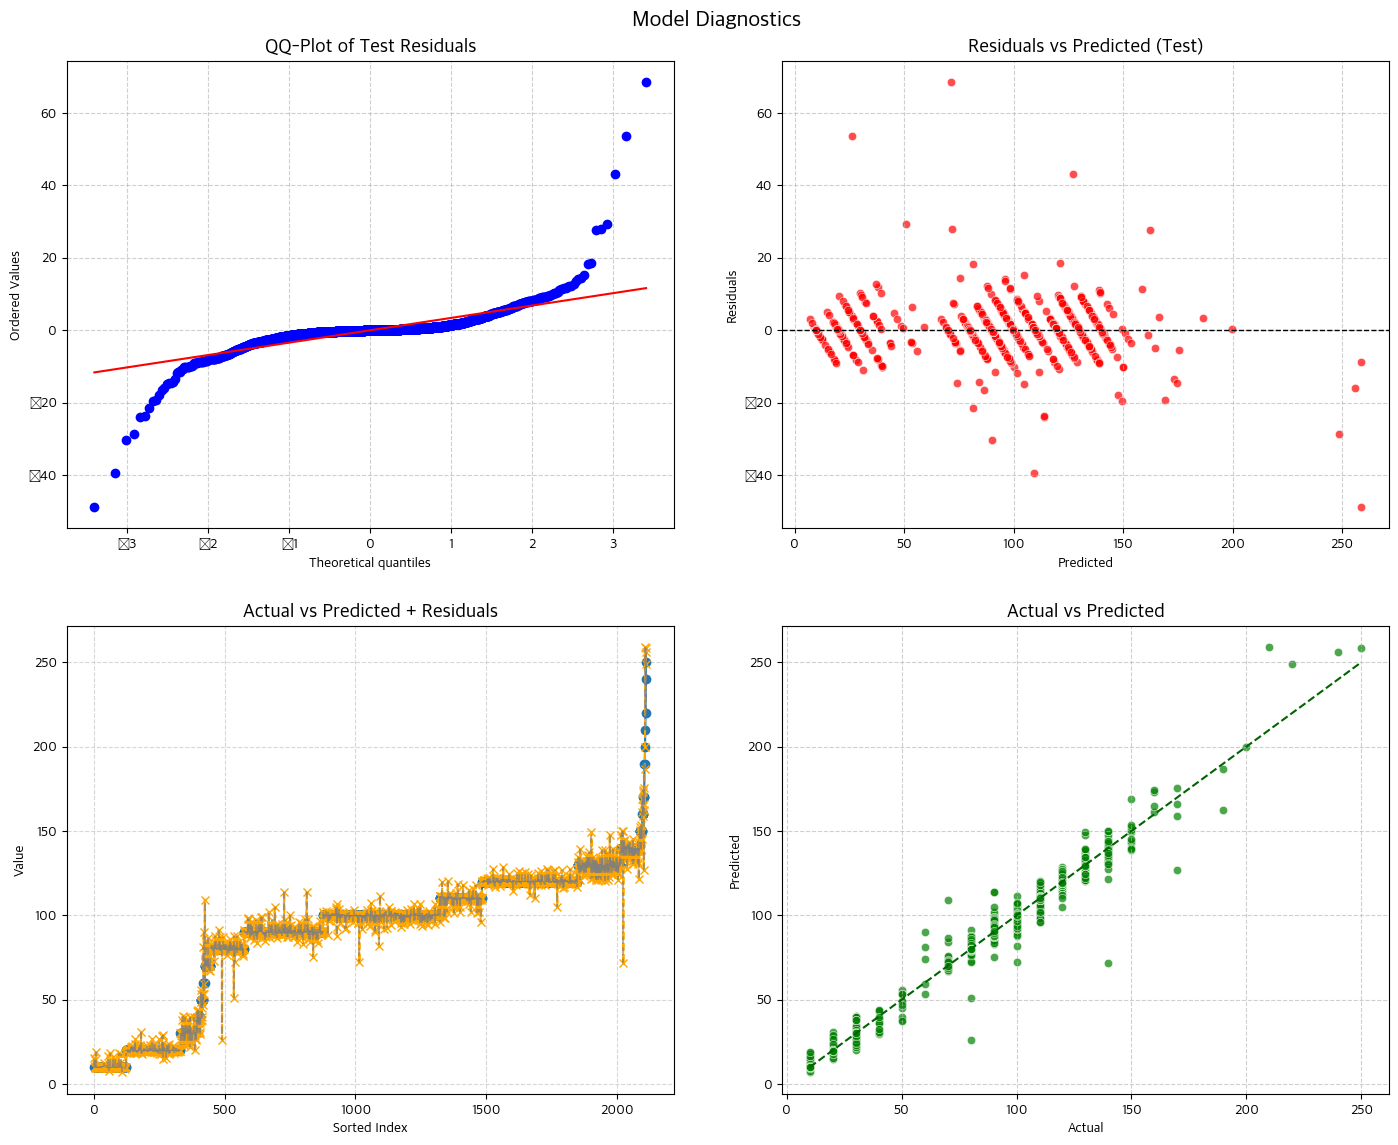

Train Accuracy
Train RMSE : 0.814
Train R2   : 1.000
Train SMAPE : 0.77
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 4.350
Test R2   : 0.987
Test SMAPE : 2.91


In [15]:
### Step Time 모델링 
# Step 1
step1_model, step1_importance = step_time_modelling(dataset, step_time='step1_time')

# Step 3
step3_model, step3_importance = step_time_modelling(dataset, step_time='step3_time')

In [16]:
### Feature Importance 
print('='*100)
print('Step1_time')
print(step1_importance)
print('-'*100)
print('Step3_time')
print(step3_importance)
print('='*100)

Step1_time
             Feature  Importance  rank
0        step1_mix온도    0.617564     1
1          step1_전력량    0.148079     2
2  step1_Rotor speed    0.076873     3
3                필팩터    0.056757     4
4             TA_MAX    0.039291     5
5             TA_MIN    0.032385     6
6             TA_AVG    0.022273     7
7       step1_Ram 압력    0.006779     8
----------------------------------------------------------------------------------------------------
Step3_time
             Feature  Importance  rank
0                필팩터    0.686663     1
1        step3_mix온도    0.114650     2
2          step3_전력량    0.084226     3
3  step3_Rotor speed    0.052614     4
4             TA_AVG    0.038057     5
5       step3_Ram 압력    0.013374     6
6             TA_MIN    0.006277     7
7             TA_MAX    0.004140     8
